<a href="https://colab.research.google.com/github/lutilipe/libras/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações Gerais

## Instalação das dependências necessárias

In [ ]:
!pip install -q mediapipe tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 793.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

## Importação de um modelo de reconhecimento das mãos

In [ ]:
!wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task

## Importação das dependências necessárias

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import tensorflow as tf


# PROCESSAMENTO DA IMAGEM

## UPLOAD DE IMAGEM

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)
IMAGE_FILENAME = list(uploaded.keys())[0]


Saving coisa_img.png to coisa_img.png


## Processar imagem

In [ ]:
def process_image(image_path):

    base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
    options = vision.GestureRecognizerOptions(base_options=base_options, num_hands=2)
    recognizer = vision.GestureRecognizer.create_from_options(options)

    image = mp.Image.create_from_file(image_path)

    recognition_result = recognizer.recognize(image)

    return recognition_result.hand_landmarks


## Desenhar landmarks

In [ ]:
def draw_landmarks(image, landmarks, color):

  for landmark in landmarks:
    height, width, _ = image.shape
    cx, cy = int(landmark.x * width), int(landmark.y * height)
    cv2.circle(image, (cx, cy), 5, color, cv2.FILLED)

## Exibir Imagem

In [ ]:
def show_image(image_path, hands_landmarks):
  colors = [(0, 255, 0), (0, 0, 255)]
  cvimage = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(cvimage, cv2.COLOR_BGR2BGRA)

  for idx, hand_landmark in enumerate(hands_landmarks):
    draw_landmarks(image_rgb, hand_landmark, colors[idx])

  cv2_imshow(image_rgb)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

# Resultado

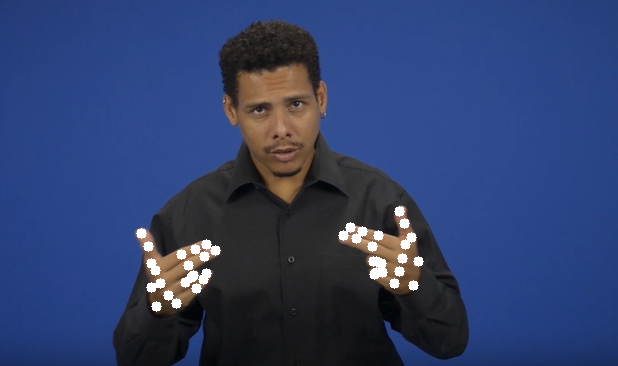

In [ ]:
landmarks = process_image(IMAGE_FILENAME)
show_image(IMAGE_FILENAME, landmarks)

In [ ]:
landmarks

[[NormalizedLandmark(x=0.1988418698310852, y=0.7584646344184875, z=7.47998342376377e-07, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.26075491309165955, y=0.7359495759010315, z=-0.02496320568025112, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3189909756183624, y=0.7032744884490967, z=-0.045727916061878204, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3734109401702881, y=0.6813191771507263, z=-0.06547322869300842, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.41619881987571716, y=0.6531308889389038, z=-0.08230850845575333, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.2790859639644623, y=0.5922874212265015, z=-0.04232770577073097, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3470863699913025, y=0.5643948316574097, z=-0.08371258527040482, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3773762285709381, y=0.5976719856262207, z=-0.11332277953624725, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.392953813076

# Processamento de vídeo

## Upload de vídeo

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)
VIDEO_FILENAME = list(uploaded.keys())[0]

Saving IMG_0637.MP4 to IMG_0637.MP4


## Processar vídeo

In [ ]:
def format_landmarks(landmarks):
  formatted_landmarks = []
  for hands_landmarks in landmarks:
    hand_landmarks = []
    for landmark in hands_landmarks:
      hand_landmarks.append([landmark.x, landmark.y, landmark.z])
  formatted_landmarks.append(np.concatenate(hand_landmarks))

  return np.concatenate(formatted_landmarks)


In [ ]:
def show_frame(frame, hands_landmarks):
  colors = [(0, 255, 0), (0, 0, 255)]


  for idx, hand_landmark in enumerate(hands_landmarks):
    draw_landmarks(frame, hand_landmark, colors[idx])

  cv2_imshow(frame)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

In [ ]:
def process_video(video_path):
  base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
  options = vision.GestureRecognizerOptions(base_options=base_options, num_hands=2)
  recognizer = vision.GestureRecognizer.create_from_options(options)

  cap = cv2.VideoCapture(video_path)

  video_frames = []

  while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

        recognition_result = recognizer.recognize(image)
        # show_frame(frame, recognition_result.hand_landmarks)

        if(len(recognition_result.hand_landmarks) > 0):
          video_frames.append(format_landmarks(recognition_result.hand_landmarks))


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

  cap.release()
  cv2.destroyAllWindows()
  return video_frames

In [ ]:
process_video('dia/IMG_0641.MP4')

# Montar base de dados para treinar o modelo



In [ ]:
labels = np.array(['oi', 'dia'])
label_map = {label:num for num, label in enumerate(labels)}
label_map

{'oi': 0, 'dia': 1}

In [ ]:

x = [] # x são os valores que vamos usar para treinar o modelo, ou seja, os landmarks
y = [] # y são apenas as labels correspondentes de cada item do array x
max_value = 0


for idx, folder_path in enumerate(labels):
  files = os.listdir(folder_path)
  for file_name in files:
    video_frames = process_video(folder_path + '/'+ file_name.decode())

    if(len(video_frames) > max_value):
      max_value = len(video_frames) # descobrir, dentre todos os vídeos, qual o número máximo de frames

    if(len(video_frames) > 0):
      x.append(video_frames)
      y.append(label_map[folder_path])


### Deixar o conjunto de dados homogeneo
É importante que todos os vídeos tenham o mesmo número de frames. Para solucionar essa questão, eu dupliquei o frame inicial por quantas vezes forem necessárias

In [ ]:
for video_frames in x:
  while(len(video_frames) < max_value):
    video_frames.insert(0, video_frames[0])



In [ ]:
x1 = np.array(x)
y = np.array(y)

### Separar o conjunto de dados de teste do conjunto de dados de treinamento

In [ ]:
x1.shape

(2, 79, 63)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = to_categorical(y).astype(int)

x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.2)


# LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(labels.shape[0], activation='softmax'))
# model.add(LSTM(64))
# model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test))


## Geração da matriz de confusão

Essa matriz serve para analisar o número de verdadeiros/falsos positivos/negativos

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

yhat = model.predict(x_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)


1/1 [==============================] - 1s 717ms/step


array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]]])

## Cálculo da precisão do modelo

In [ ]:
accuracy_score(ytrue, yhat)

1.0

### Salvar os pesos do modelo

In [ ]:
model.save('libras.h5')

### Testando o modelo com dados que ele nunca viu

In [ ]:
new_video = np.array(process_video('teste/OI.mp4'))


print(np.array([new_video]).shape)

result = model.predict(np.array([new_video]))

category = labels[np.argmax(result[0])]
print(category)

(1, 61, 63)
1/1 [==============================] - 0s 33ms/step
oi
